# RNN Model

## Data Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from keras.layers import SimpleRNN, Dense, BatchNormalization
from keras.models import Sequential
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [4]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [ ]:
def create_model():
    model = Sequential()
    model.add(
        SimpleRNN(
            128,
            input_shape=(X_train.shape[1], 1),
            activation="relu"
        )
    )
    model.add(Dense(10, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
model.summary()
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 512)               263168    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 270357 (1.03 MB)
Trainable params: 269333 (1.03 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 5s 14ms/step - loss: 0.2318 - 

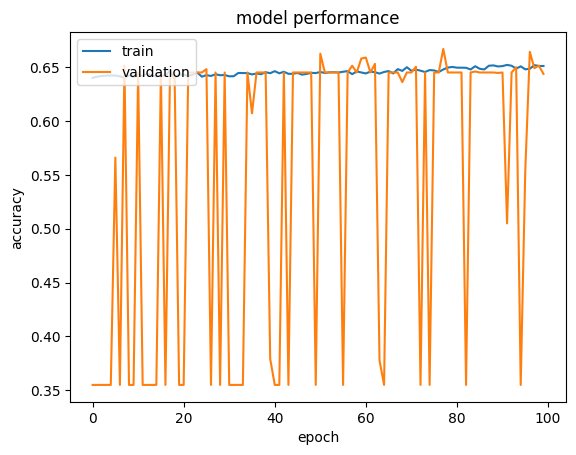

In [ ]:
plot_hist(history)

In [ ]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 4ms/step
Accuracy:  0.643621766280107

Confusion Matrix: 
 [[1443    3]
 [ 796    0]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      1446
         1.0       0.00      0.00      0.00       796

    accuracy                           0.64      2242
   macro avg       0.32      0.50      0.39      2242
weighted avg       0.42      0.64      0.51      2242



### Tuned Model


In [5]:
def tune_model(hp):
    units = hp.Choice('units', [128, 256, 512])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    batch_norm = hp.Boolean('batch_norm')

    model = Sequential()
    model.add(
        SimpleRNN(
            units=units,
            input_shape=(X_train.shape[1], 1),
            activation=activation
        )
    )
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dense(10, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    return model

tuner = kt.GridSearch(
    tune_model,
    objective='val_accuracy',
    max_trials=10
)

tuner.search(X_train, y_train, epochs = 20, validation_split = 0.2)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [6]:
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [7]:
best_model.summary()
history = best_model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 512)               263168    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 270357 (1.03 MB)
Trainable params: 269333 (1.03 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 5s 14ms/step - loss: 0.2318 - 

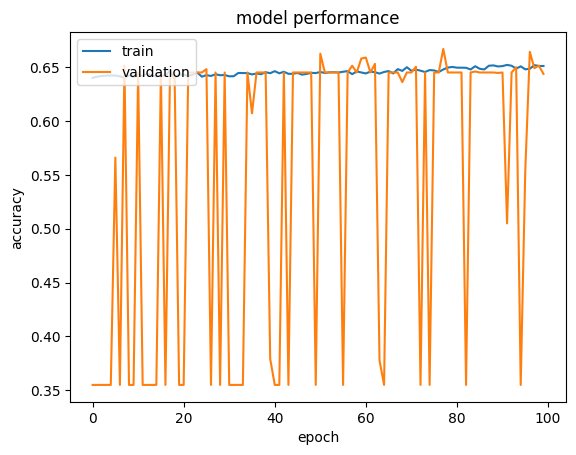

In [8]:
plot_hist(history)

In [9]:
# print confusion matrix and accuracy
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 4ms/step
Accuracy:  0.643621766280107

Confusion Matrix: 
 [[1443    3]
 [ 796    0]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      1446
         1.0       0.00      0.00      0.00       796

    accuracy                           0.64      2242
   macro avg       0.32      0.50      0.39      2242
weighted avg       0.42      0.64      0.51      2242

